In [26]:
"""
Author:  Cory Padgett
Advisor: Dr. Jeffrey Fung
Email:   cpadge4@clemson.edu
"""

#imports
import io
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import requests


#-------------------------------------------------------------------------------------------------------
#constants
#-------------------------------------------------------------------------------------------------------
#system constants to edit
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------
MASS_STAR   = 1.02 * 1.989 * 10**33   #mass of star [g]
INCLIN  = np.radians(71.0)      #inclination of disk [radians]
T0      = 2770           #initial temperature [K]
ALPHA   = -0.33          #temperature power law constant
N0      = 1.0E19         #initial density [1/cm^2]
BETA    = -2.0           #density power law constant
R_IN    = 0.048          #inner radius [au]
R_OUT   = 0.898          #outer radius [au]
B       = 8.8            #gaussian spread constant [km/s]
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

#general constants
PLANCK     = 6.626068 * 10**(-27)      #erg s       Planck’s Constant
BOLTZ      = 0.6950348                 #cm^-1 K^-1  Boltzman’s Constant
BOLTZ_CGS  = 1.380649 * 10**(-16)      #erg K^-1  Boltzman’s Constant
C          = 2.997925 * 10**10         #cm s^-1     Speed of light in vacuum
G          = 6.674 * 10**(-8)          #cm^3 g^−1 s^−2
R          = 8.31446261815324 * 10**7  #erg K^-1 mol^-1
MOL        = 6.022 * 10*23
AU_CM      = 1.496 * 10**13     #cm
AU_KM      = 1.496 * 10**8      #km
MASS_SOL   = 1.989 * 10**33     #g
MASS_JUP   = 1.898 * 10**30     #g
B_CGS      = B * 100000         #cm/s

#arrays
k_vel = np.linspace(-300,300,601)      #velocity space to test [km/s]


In [27]:
def load_spec_data():
    # Load the spectrum data
    spec_data = io.BytesIO(requests.get('https://osf.io/t7v8s/download').content).read().decode('utf-8').split('\n')

    # Initialize arrays
    vel_j = []
    ein_j = []
    eng_j = []
    g1j = []
    g0j = []

    # Process each line in spec_data
    for line in spec_data:
        co_data = line.split()
        if len(co_data) > 1:  # Check if the line is not empty
            vel_j.append(float(co_data[1]))
            ein_j.append(float(co_data[2]))
            eng_j.append(float(co_data[3]))
            g1j.append(float(co_data[8]))
            g0j.append(float(co_data[9]))

    print("Spectrum Data Loaded")

    # Load the thermal data
    part_data = io.BytesIO(requests.get('https://osf.io/5g6wm/download').content).read().decode('utf-8').split('\n')

    # Initialize arrays
    temp = []
    part = []

    # Process each line in part_data
    for line in part_data:
        part_line = line.split()
        if len(part_line) > 1:  # Check if the line is not empty
            temp.append(float(part_line[0]))
            part.append(float(part_line[1]))

    print("Thermal Data Loaded")

    return vel_j, ein_j, eng_j, g1j, g0j, temp, part


def load_circular_2d():
    #circular slab model
    x_len   = 2160
    y_len   = 1200
    lengths = x_len, y_len

    radius = np.zeros((x_len,y_len))
    theta  = np.zeros((x_len,y_len))

    rad = np.linspace(R_IN, R_OUT, x_len)
    the = np.linspace(0.0, 2*np.pi, y_len)

    for i in range(0,x_len):
        for j in range(0,y_len):
            radius[:,j] = rad
            theta[i,:]  = the
    radius = np.transpose(radius)
    theta  = np.transpose(theta)
    radius = cell_center_2D(radius)
    theta  = cell_center_2D(theta)
    grids  = radius, theta

    temp    = T0 * (radius/R_IN)**ALPHA
    density = N0 * (radius/R_IN)**BETA
    vel     = np.sqrt(G * MASS_STAR / (radius*AU_CM)) * np.sin(theta) * np.sin(INCLIN) / 100000
    data    = density, temp, vel

    return grids, lengths, data


def cell_center_2D(xa):
    x, y = np.shape(xa)
    Nx = x-1
    Ny = y-1
    xc = np.zeros((Nx,Ny),dtype=np.float64)

    for i in range(Nx):
        for j in range(Ny):
            xc[i,j] = (xa[i+1,j+1]+xa[i,j])/2.0
    return xc


def part_func_1D(temp, part, x_len):
    #generates 1d partion function grid from 1d radial temperatures
    part_func = np.zeros((np.shape(temp)))
    for i in range(0, x_len-1):
        if temp[0,i] > 8999.0:
            part_func[:,i] = part[-1]
        else:
            part_func[:,i] = part[int(temp[0,i])]
    return part_func

def flux_cal(density, vel_j, ein_j, eng_j, g1j, g0j, temp, part_func):
    #calculates the flux of the disk for given transition lines
    constant1 = 1 / (8 * B_CGS * (np.pi)**(3./2.))
    x, y      = np.shape(density)
    optical_t = np.zeros((len(g0j), x, y))
    flux_dens = np.zeros((x, y))

    for i in range(len(g0j)):
        #loops through the different transitions
        opt_depth        = (density / part_func)  * np.exp(-eng_j[i] / (BOLTZ * temp)) * (ein_j[i] * g0j[i]**2 / (g1j[i] * vel_j[i]**3)) * constant1
        optical_t[i,:,:] = opt_depth.astype(float)
        planck_func      = (2 * PLANCK * C * vel_j[i]**3) / (np.exp((PLANCK * C * vel_j[i])/(BOLTZ_CGS * temp)) - 1)
        flux_dens       += (1-np.exp(-opt_depth.astype(float))) * vel_j[i]/ C * planck_func
    return flux_dens


def int_j_cal(flux_dens, radius, k_vel, vzp):
    #line density calculation
    int_j = np.zeros(np.shape(k_vel))
    constant2 = 1 / (B_CGS * np.sqrt(np.pi))

    flux_radius = flux_dens * radius**2 * AU_KM
    for i in range(len(k_vel)):
        #loops through the test speeds
        int_j[i] = np.sum(flux_radius * constant2 * np.exp(-(k_vel[i] - vzp)**2 / B**2))
    return int_j

In [28]:
#load spectrum data
vel_j, ein_j, eng_j, g1j, g0j, temp, part = load_spec_data()

#load circular slab model
grids, lengths, data = load_circular_2d()
radius, theta = grids
x_len, y_len  = lengths
density, temp, vel = data

Spectrum Data Loaded
Thermal Data Loaded


In [29]:
#----------------------------------------------------------------------------------------------
#Line Desnsity Calculation
#----------------------------------------------------------------------------------------------
part_func = part_func_1D(temp, part, y_len)
flux_dens = flux_cal(density, vel_j, ein_j, eng_j, g1j, g0j, temp, part_func)
int_j     = int_j_cal(flux_dens, radius, k_vel, vel)
print("Calculations Done!")

<ipython-input-27-9ed5daf309e9>:133: RuntimeWarning: divide by zero encountered in divide
  opt_depth        = (density / part_func)  * np.exp(-eng_j[i] / (BOLTZ * temp)) * (ein_j[i] * g0j[i]**2 / (g1j[i] * vel_j[i]**3)) * constant1


Calculations Done!


In [34]:
def plot_line(int_j):
    #plot ro-vibrational line density

    max_int_j = np.max(int_j)      #normalize calculated line to peak at 1
    int_j     = int_j / max_int_j

    fig, ax = plt.subplots()
    ax.plot(k_vel,int_j)
    plt.xlabel("Velocity [km/s]")
    plt.ylabel("Normalized Flux")
    plt.title("Line Density")
    return

def plot_pol_dens(radius, theta, density):
    #Polar Density Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))
    ax.grid(False)
    plt.pcolormesh(theta, radius, np.log10(density))
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)   # Move radial labels away from plotted line
    plt.colorbar(label="[log(cm-2)]")
    ax.set_title("Calculated Densities")
    return


def plot_pol_vzp(radius, theta, vzp):
    #Polar Inclined Velocity Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.grid(False)
    plt.pcolormesh(theta, radius, vzp, vmin=-150.0, vmax=150.0)
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    plt.colorbar(label="[km/s]")
    ax.set_title("Projected Velocities")
    return


def plot_line_dens(radius, theta, density, int_j):

    max_int_j = np.max(int_j)       #normalize calculated line to peak at 1
    int_j     = int_j / max_int_j

    #Multi Plot - polar density and line
    fig = plt.figure(figsize=(12, 5))
    ax0 = plt.subplot(121, projection='polar')
    ax1 = plt.subplot(122)

    fig.suptitle('Orbit ', fontsize=16)

    ax0.grid(False)
    cset0 = ax0.pcolormesh(theta, radius, np.log10(density))
    ax0.set_ylim(0,0.3)
    ax0.set_title("Calculated Densities", fontsize=15)

    ax1.plot(k_vel, int_j)
    ax1.set_xlabel("Velocities [km/s]", fontsize=12)
    ax1.set_ylabel("Normalized Flux",   fontsize=12)
    ax1.set_xlim(-200,200)

    fig.colorbar(cset0, ax=ax0, label="[log(cm-2)]")
    ax1.set_title("Line Density", fontsize=15)
    return

def plot_pol_temp(radius, theta, temp):
    #Polar Temperature Map

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.grid(False)
    plt.pcolormesh(theta, radius, temp)
    ax.set_rmax(0.3)
    ax.set_rticks([0.1, 0.2, 0.3])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    plt.colorbar(label="[k]")
    ax.set_title("Surface Temperature of Disk")
    return

def plot_temp(radius, temp):
    #Polar Temperature Map

    fig, ax = plt.subplots()
    plt.plot(radius[0,:], temp[0,:])
    plt.xlabel("Radius [au]")
    plt.ylabel("Temperature [k]")
    ax.set_title("Surface Temperature of Disk")
    return


def plot_dens(radius, dens):
    #Polar Temperature Map

    fig, ax = plt.subplots()
    plt.plot(radius[0,:], dens[0,:])
    plt.yscale("log")
    plt.xlabel("Radius [au]")
    plt.ylabel("Density [log10(1/cm^2)]")
    ax.set_title("Surface Density of Disk")
    return

Plotting Done!


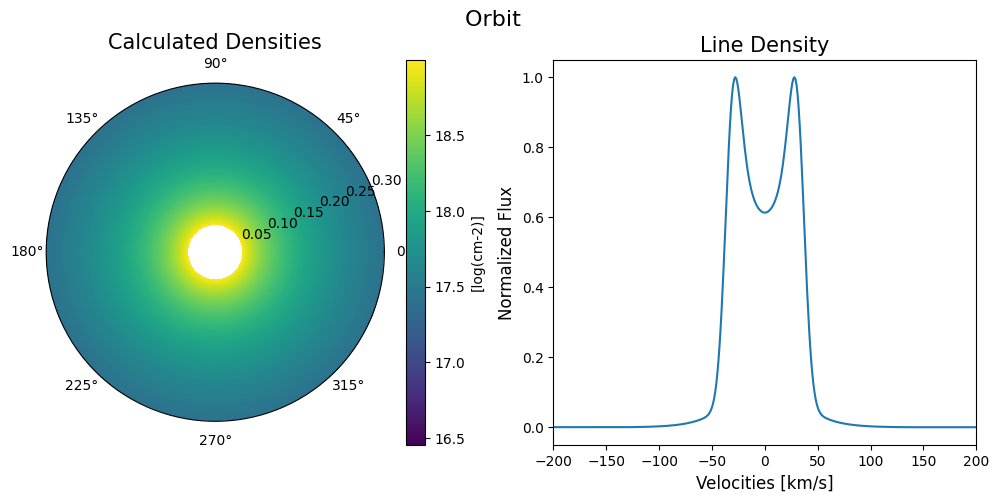

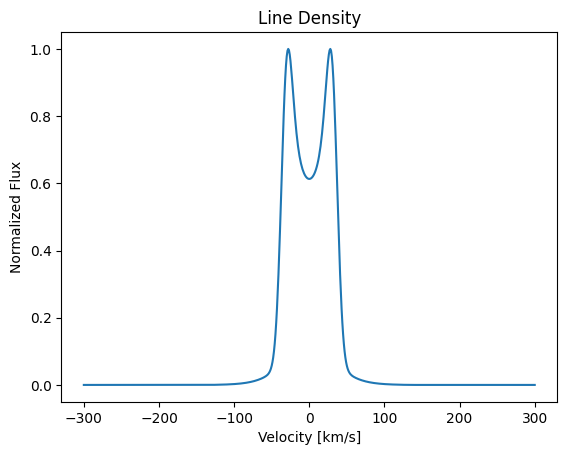

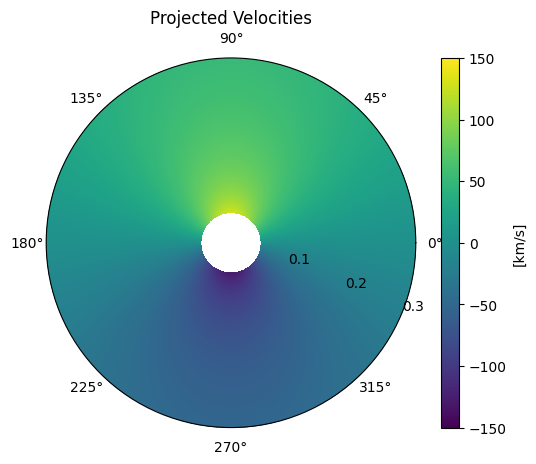

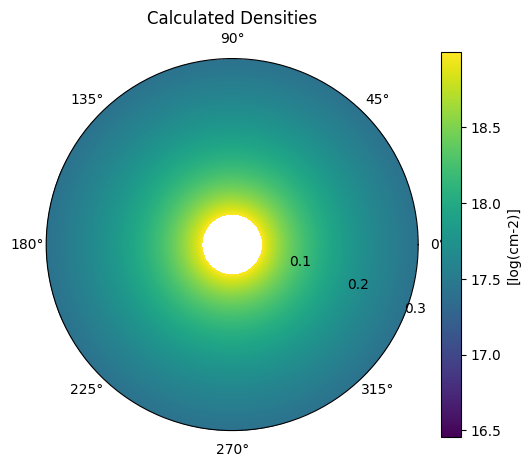

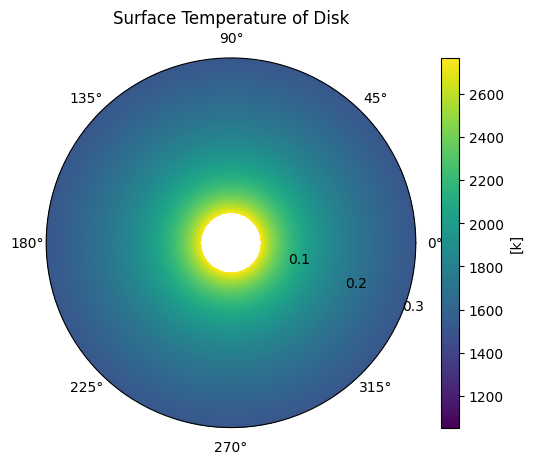

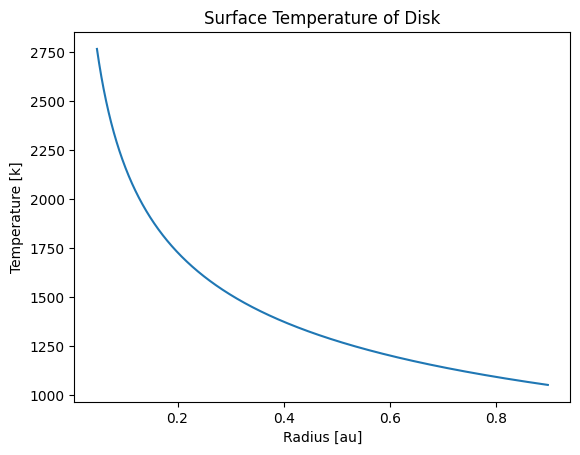

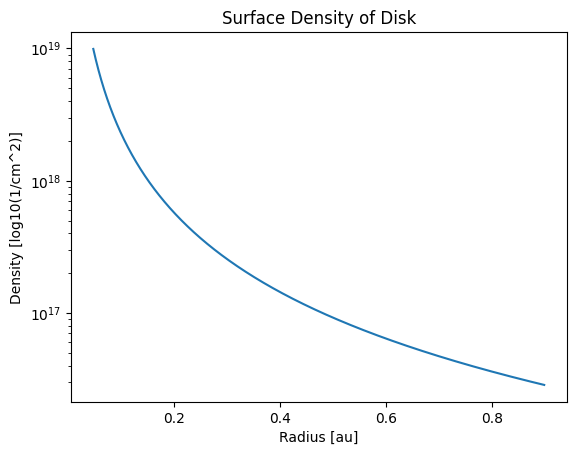

In [35]:
#----------------------------------------------------------------------------------------------
#Plotting
#----------------------------------------------------------------------------------------------
plot_line_dens(radius, theta, density, int_j)
plot_line(int_j)

plot_pol_vzp(radius, theta, vel)
plot_pol_dens(radius, theta, density)
plot_pol_temp(radius, theta, temp)
plot_temp(radius, temp)
plot_dens(radius, density)
print("Plotting Done!")